# Etape 1: Préparation des données

In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemins vers les fichiers CSV
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

# Labels d’émotions
emotion_labels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear',
    3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

In [14]:
# Dataset personnalisé PyTorch
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = int(self.df.iloc[idx]['emotion'])
        pixels = np.fromstring(self.df.iloc[idx]['pixels'], sep=' ', dtype=np.float32)
        image = pixels.reshape(48, 48)

        image = Image.fromarray(image).convert('L')  

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformation : conversion en tensor + normalisation
transform = transforms.Compose([
    transforms.ToTensor(),  # [0, 255] → [0.0, 1.0]
    transforms.Normalize((0.5,), (0.5,))  # centrage sur 0
])

# Création des datasets
full_train_dataset = EmotionDataset(train_df, transform=transform)
test_dataset = EmotionDataset(test_df, transform=transform)

# Split train / validation (80/20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

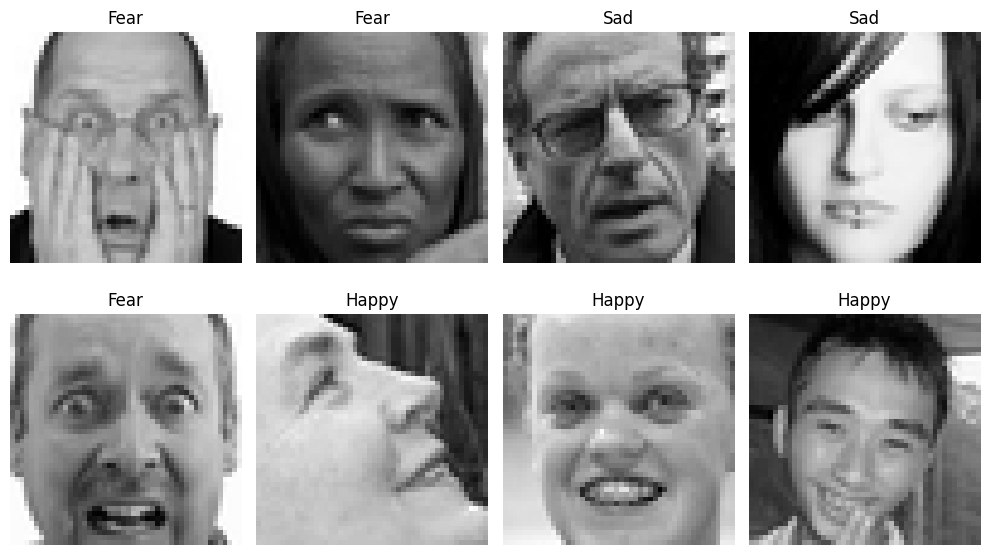

In [15]:
# Affichage de quelques images avec labels
def show_batch(loader):
    images, labels = next(iter(loader))
    plt.figure(figsize=(10, 6))
    for i in range(8):
        plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(emotion_labels[labels[i].item()])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_batch(train_loader)

L’analyse manuelle de certaines images montre que le label attribué peut prêter à confusion (ex : expression ‘Fear’ perçue comme ‘Sad’). Cela impacte l’apprentissage et la qualité des prédictions. Il est important de garder à l’esprit la subjectivité et la variabilité des annotations émotionnelles.

# Etape 2: Définir le modèle CNN

Architecture: CONV → POOL → CONV → POOL → FC → FC

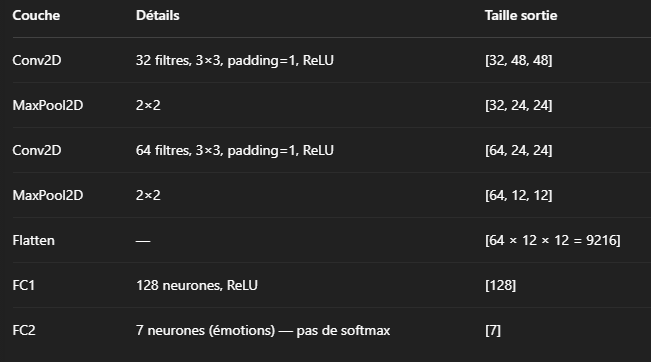

In [16]:
import torch.nn as nn
import torch.nn.functional as F

class EmotionCNN(nn.Module):
    def __init__(self):
        super(EmotionCNN, self).__init__()

        # Blocs convolutionnels
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 7)  # 7 émotions

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))   # 48 → 24
        x = self.pool(F.relu(self.conv2(x)))   # 24 → 12
        x = x.view(-1, 64 * 12 * 12)           # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                        # Pas de softmax ici parce que CrossEntropyLoss intègre déjà softmax dans son calcul interne
        return x

In [17]:
# Test avec un batch pour vérifier que ça tourne
model = EmotionCNN().to(device)
sample = next(iter(train_loader))[0].to(device)
out = model(sample)
print("Sortie modèle :", out.shape)  # doit donner [batch_size, 7]

Sortie modèle : torch.Size([64, 7])


# Etape 3: Optimisation du modèle CNN

Dans cette partie, nous analysons en détail le comportement de la fonction de perte pendant l'entraînement, en mettant l'accent sur les différents algorithmes d'optimisation et leurs hyperparamètres (notamment le learning rate α et le momentum β).

Étudier l’impact des hyperparamètres de l’optimiseur SGD sur la convergence du modèle :

Variation du learning rate α

Variation du momentum β

On cherche à trouver les meilleures valeurs pour un entraînement final performant.

### Utilisation de la fonction de perte : Loss function

La CrossEntropyLoss (log-loss) est la fonction de perte classique pour les problèmes de classification multi-classes. Elle mesure la distance entre :

* Les logits de sortie du modèle (non normalisés),

* Et les vraies classes (sous forme d’index, pas one-hot).

Elle pousse le modèle à prédire une forte probabilité pour la bonne classe.

#### Nature de la fonction de perte
❌ Est-elle convexe ?
* Non. Même si la fonction de cross-entropie seule est convexe (quand appliquée à une softmax), le modèle complet (CNN) n’est pas une fonction convexe.

➡️ Pourquoi ?

* Le réseau contient des fonctions non linéaires : ReLU, convolutions, couches fully connected...

* Il est profond, avec de nombreuses compositions non linéaires.

Donc, la surface d’erreur peut contenir :

* Des minima locaux,

* Des plateaux,

* Des selles.

✅ Est-elle différentiable ?
* Oui, presque partout.

💡 Cela suffit pour appliquer des méthodes d’optimisation de 1er ordre comme SGD, Adam, etc.

Epoch 1 - Loss: 1.7822
Epoch 2 - Loss: 1.7012
Epoch 3 - Loss: 1.6496
Epoch 4 - Loss: 1.6245
Epoch 5 - Loss: 1.6009
Epoch 6 - Loss: 1.5774
Epoch 7 - Loss: 1.5541
Epoch 8 - Loss: 1.5294
Epoch 9 - Loss: 1.5065
Epoch 10 - Loss: 1.4844


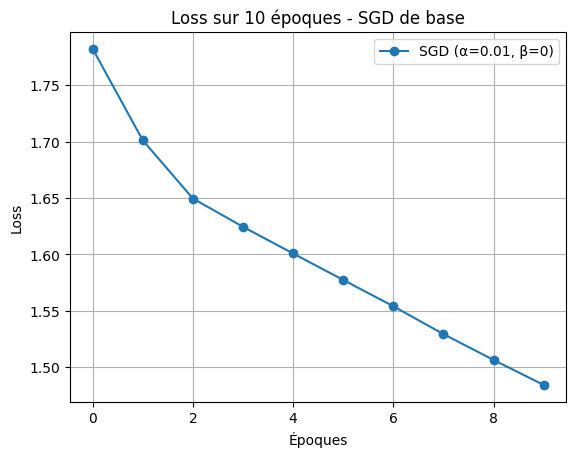

In [18]:
def train_sgd_base(epochs=10):
    model = EmotionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # α = 0.01, sans momentum

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f"Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
    
    return losses

# Entraînement + Affichage
losses_base = train_sgd_base()

plt.plot(losses_base, marker='o', label='SGD (α=0.01, β=0)')
plt.title("Loss sur 10 époques - SGD de base")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()


Interprétation de la courbe de loss avec SGD

📉 Observation :
* La courbe décroît de manière continue et régulière entre l’époque 1 et 10.

* La perte passe de ~1.81 à ~1.45 en 10 époques.

📌 Interprétation :
* Cela montre que SGD apprend correctement : le réseau réduit l’erreur au fil des itérations.

* Cependant, la courbe reste assez lente → la convergence n’est pas très rapide. -> Ca m'a pris 10 minutes 

🎯 C’est typique de SGD "pur", sans techniques avancées comme momentum ou adaptation de learning rate.


### Test de plusieurs taux d'apprentissage a

α = 0.001 - Epoch 1 - Loss: 1.8894
α = 0.001 - Epoch 2 - Loss: 1.8263
α = 0.001 - Epoch 3 - Loss: 1.8081
α = 0.001 - Epoch 4 - Loss: 1.7992
α = 0.001 - Epoch 5 - Loss: 1.7921
α = 0.001 - Epoch 6 - Loss: 1.7851
α = 0.001 - Epoch 7 - Loss: 1.7777
α = 0.001 - Epoch 8 - Loss: 1.7706
α = 0.001 - Epoch 9 - Loss: 1.7637
α = 0.001 - Epoch 10 - Loss: 1.7570
α = 0.010 - Epoch 1 - Loss: 1.7939
α = 0.010 - Epoch 2 - Loss: 1.7205
α = 0.010 - Epoch 3 - Loss: 1.6583
α = 0.010 - Epoch 4 - Loss: 1.6236
α = 0.010 - Epoch 5 - Loss: 1.5997
α = 0.010 - Epoch 6 - Loss: 1.5791
α = 0.010 - Epoch 7 - Loss: 1.5567
α = 0.010 - Epoch 8 - Loss: 1.5335
α = 0.010 - Epoch 9 - Loss: 1.5104
α = 0.010 - Epoch 10 - Loss: 1.4896
α = 0.100 - Epoch 1 - Loss: 1.7054
α = 0.100 - Epoch 2 - Loss: 1.5347
α = 0.100 - Epoch 3 - Loss: 1.4089
α = 0.100 - Epoch 4 - Loss: 1.3098
α = 0.100 - Epoch 5 - Loss: 1.2139
α = 0.100 - Epoch 6 - Loss: 1.1189
α = 0.100 - Epoch 7 - Loss: 1.0143
α = 0.100 - Epoch 8 - Loss: 0.8895
α = 0.100 - Epoch 

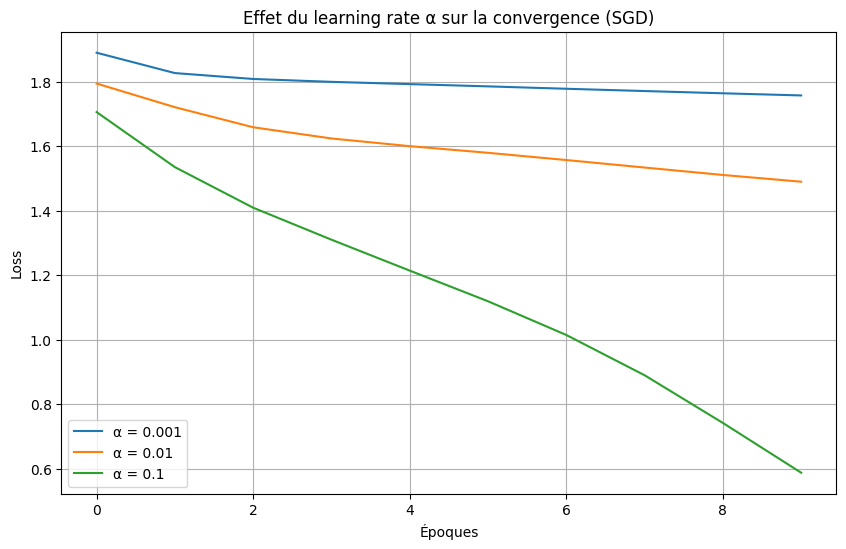

In [10]:
def train_with_sgd(alpha, epochs=10):
    model = EmotionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=alpha)

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f"α = {alpha:.3f} - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
    return losses

# Test des learning rates
losses_001 = train_with_sgd(0.001)
losses_01 = train_with_sgd(0.01)
losses_1 = train_with_sgd(0.1)

# 📊 Courbe
plt.figure(figsize=(10, 6))
plt.plot(losses_001, label='α = 0.001')
plt.plot(losses_01, label='α = 0.01')
plt.plot(losses_1, label='α = 0.1')
plt.title("Effet du learning rate α sur la convergence (SGD)")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

### Intéprétation après avoir varier la paramètre Alpha du SGD
🔵 α = 0.001 : courbe quasiment plate

🟠 α = 0.01 : descente régulière

🟢 α = 0.1 : descente rapide et constante

### 🔵 1. SGD avec α = 0.001

* Comportement : la loss diminue à peine, très lentement : 1.8926 → 1.8028

Interprétation :

* Le pas d’apprentissage est trop petit

* L’optimiseur fait de mini-pas, donc met beaucoup de temps à converger

* On risque d’avoir besoin de beaucoup plus d’époques

✅ Stable mais trop lent → inefficace en pratique

### 🟠 2. SGD avec α = 0.01 (valeur de référence)

* Comportement : la loss descend bien : 1.8160 → 1.5997

Interprétation :

* Bon compromis entre vitesse et stabilité

* Permet de s’approcher du minimum en un nombre d’époques raisonnable

✅ C’est une valeur standard souvent utilisée en pratique avec SGD

### 🟢 3. SGD avec α = 0.1

* Comportement : la loss descend très vite : 1.7537 → 0.8542

Interprétation :

* Convergence très rapide

* Ici, le learning rate est efficace mais pas trop grand → pas d'instabilité

* On aurait pu avoir des oscillations, mais ici le modèle les a bien tolérées

✅ Très bonne performance dans ce cas précis, mais risqué sur d’autres datasets plus sensibles

CONCLUSION sur l'Optimisation
➤ 1. Le taux d’apprentissage 𝛼 est critique
* Trop bas → sous-apprentissage

* Trop haut → instabilité ou divergence (pas vu ici, mais possible dans d'autres cas) 

➤ 2. La fonction de perte n’est pas convexe
* Donc il n’y a aucune garantie d’atteindre le minimum global

* Mais grâce à la descente de gradient et une bonne valeur de α, on peut trouver un minimum local acceptable

Ce comportement est accentué par la non-convexité de la fonction de perte (due à la structure CNN), mais SGD permet tout de même de converger vers des minima locaux valides.
La fonction de perte étant non convexe, plusieurs minima locaux peuvent exister.
Le choix du taux d’apprentissage ou du moment (momentum) a une influence importante sur la capacité de l’algorithme à atteindre un minimum local performant, sans rester bloqué dans un sous-optimum.

### Test de plusieurs valeurs de momentum beta

Le momentum est une méthode visant à améliorer la descente de gradient en ajoutant une composante inertielle.
Au lieu de s'appuyer uniquement sur le gradient actuel, l'algorithme cumule l'historique des gradients pour suivre une trajectoire plus fluide.
Cela permet une meilleure stabilité, une convergence plus rapide, et une meilleure robustesse face à la non-convexité de la fonction de perte.

* On a fait varier alpha, le learning rate, maintenant on joue sur Beta, le momentum

🎓 1. Intuition simple
Imagine une balle qui roule dans une vallée ⛰️ :

* Sans friction → elle va accélérer dans la pente

* Si elle atteint un creux (minimum local), l’élan accumulé peut l’aider à le dépasser et continuer vers un minimum plus bas

🎯 C’est exactement ça que le momentum fait en optimisation :

Il ajoute une mémoire du passé pour ne pas s'arrêter trop vite et gagner de la vitesse dans la bonne direction.

Comportement attendu
* Plus fluide : moins d’oscillations, surtout quand la pente change brutalement

* Plus rapide : car l'optimiseur accumule de la vitesse dans la "bonne" direction

* Moins sensible à de petits minimums locaux

Grâce au momentum dans notre CNN:

* On évite de trop ralentir dans les régions plates de la loss

* On peux sauter des minima locaux (faibles creux)

* On accélères la convergence sans augmenter 𝛼


β = 0.50 - Epoch 1 - Loss: 1.7663
β = 0.50 - Epoch 2 - Loss: 1.6544
β = 0.50 - Epoch 3 - Loss: 1.6019
β = 0.50 - Epoch 4 - Loss: 1.5558
β = 0.50 - Epoch 5 - Loss: 1.5128
β = 0.50 - Epoch 6 - Loss: 1.4678
β = 0.50 - Epoch 7 - Loss: 1.4202
β = 0.50 - Epoch 8 - Loss: 1.3757
β = 0.50 - Epoch 9 - Loss: 1.3357
β = 0.50 - Epoch 10 - Loss: 1.2984
β = 0.90 - Epoch 1 - Loss: 1.6910
β = 0.90 - Epoch 2 - Loss: 1.5124
β = 0.90 - Epoch 3 - Loss: 1.3861
β = 0.90 - Epoch 4 - Loss: 1.2916
β = 0.90 - Epoch 5 - Loss: 1.2063
β = 0.90 - Epoch 6 - Loss: 1.1132
β = 0.90 - Epoch 7 - Loss: 1.0030
β = 0.90 - Epoch 8 - Loss: 0.8814
β = 0.90 - Epoch 9 - Loss: 0.7507
β = 0.90 - Epoch 10 - Loss: 0.6023
β = 0.99 - Epoch 1 - Loss: 1.7168
β = 0.99 - Epoch 2 - Loss: 1.5085
β = 0.99 - Epoch 3 - Loss: 1.4444
β = 0.99 - Epoch 4 - Loss: 1.3870
β = 0.99 - Epoch 5 - Loss: 1.3522
β = 0.99 - Epoch 6 - Loss: 1.2863
β = 0.99 - Epoch 7 - Loss: 1.2212
β = 0.99 - Epoch 8 - Loss: 1.1665
β = 0.99 - Epoch 9 - Loss: 1.0999
β = 0.99 - E

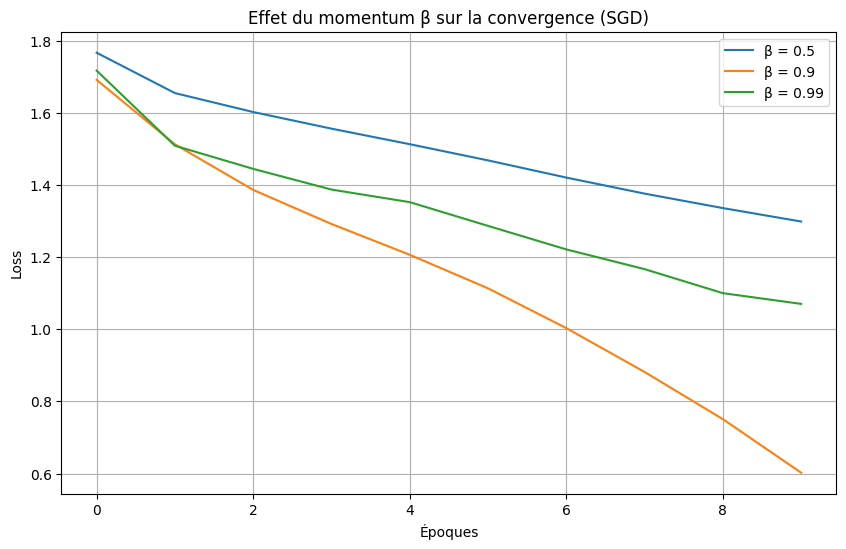

In [11]:
def train_with_momentum(beta, epochs=10):
    model = EmotionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=beta)

    losses = []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        losses.append(epoch_loss)
        print(f"β = {beta:.2f} - Epoch {epoch+1} - Loss: {epoch_loss:.4f}")
    return losses

# Test des momentums
losses_05 = train_with_momentum(0.5)
losses_09 = train_with_momentum(0.9)
losses_099 = train_with_momentum(0.99)

# 📊 Courbe
plt.figure(figsize=(10, 6))
plt.plot(losses_05, label='β = 0.5')
plt.plot(losses_09, label='β = 0.9')
plt.plot(losses_099, label='β = 0.99')
plt.title("Effet du momentum β sur la convergence (SGD)")
plt.xlabel("Époques")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

🔵 β = 0.5
* Perte finale : 1.2984

* Courbe : Descente lente, mais régulière

Interprétation :

* Le momentum est trop faible → n’apporte pas assez d’élan

* Le modèle se comporte presque comme un SGD "classique"

✅ Stable, ❌ peu rapide

🟠 β = 0.9
* Perte finale : 0.6023

* Courbe : Descente rapide, très régulière

Interprétation :

* C’est le meilleur résultat ici

* L’élan accumulé par le gradient aide à descendre plus vite et plus profondément

✅ Excellent compromis entre vitesse et stabilité

➕ Moins de risque de rester bloqué dans des minimums locaux

🟢 β = 0.99
* Perte finale : 1.0702

* Courbe : Moins fluide, avec rebonds

Interprétation :

* Le momentum est trop fort → le modèle continue trop sur son élan

* Oscillations → il réagit moins bien aux changements de direction du gradient

❌ Convergence moins efficace

β = 0.9 offre la meilleure convergence dans ce contexte : plus rapide et atteignant une perte bien plus basse.

Trop de momentum (0.99) ralentit au lieu d’accélérer.

D'ailleurs note: Pourquoi des oscillations quand β est trop grand ?
* Trop de mémoire du passé : Avec β = 0.99, le gradient accumule presque tout l'historique, Si la direction du gradient change (ce qui arrive souvent dans une fonction non convexe, comme ici), le modèle continue d’avancer dans une "ancienne" direction au lieu de s’adapter.
→ Résultat : il dépasse le minimum local → il repart dans l'autre sens → oscillation.

* Pas d'amortissement : Le modèle ne ralentit pas assez en approchant le minimum. Il "rebondit" autour du minimum car le momentum le pousse trop loin à chaque update.

* Surface non convexe : Comme on l’a dit, la surface de la loss n’est pas plate. Donc, un gros momentum ne suit pas bien les virages dans cette surface. D’où des rebonds, et même parfois des divergences si le learning rate est trop grand

CONCLUSION:

L’ajout d’un momentum (β = 0.9) a permis :

* D’accélérer la convergence

* De lisser les descentes du gradient

* D’atteindre une perte plus faible en moins de temps

Cela s’explique par le fait que l’optimiseur accumule l’historique des gradients pour renforcer les directions constantes et atténuer les variations instables (paliers, rebonds, petits minimums).

IMPACT SUR LA NON CONVEXITE :
* Grâce au momentum, l’optimisation est moins affectée par les minima locaux. L’élan accumulé permet au modèle de ne pas "rester coincé" dans des vallées peu profondes.

CONCLUSION pour B= 0.9
* Momentum est un ajout simple mais très efficace à SGD

* Il n'améliore pas la fonction de perte elle-même, mais l'algorithme qui cherche son minimum

* Dans des cas non convexes (comme ici avec un CNN), il est souvent essentiel pour de bonnes performances


# Etape 4 : Entraînement du modèle

Learning rate α = 0.1

Momentum β = 0.9

Ces paramètres ont donné les meilleurs résultats (convergence rapide, stable, bonne loss).

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# Initialisation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmotionCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

n_epochs = 30
patience = 5
best_val_loss = float('inf')
patience_counter = 0

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Accuracy function
def compute_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total

# Entraînement complet
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = compute_accuracy(model, train_loader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_acc = compute_accuracy(model, val_loader)

    # Logs
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"[{epoch+1}/{n_epochs}] - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
          f"Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # EarlyStopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Nouvelle meilleure Val Loss — modèle sauvegardé !")
    else:
        patience_counter += 1
        print(f"Patience : {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping déclenché !")
            break


[1/30] - Train Loss: 1.6487 | Val Loss: 1.5569 | Train Acc: 42.61% | Val Acc: 39.92%
Nouvelle meilleure Val Loss — modèle sauvegardé !
[2/30] - Train Loss: 1.5154 | Val Loss: 1.5153 | Train Acc: 45.51% | Val Acc: 40.72%
Nouvelle meilleure Val Loss — modèle sauvegardé !
[3/30] - Train Loss: 1.4378 | Val Loss: 1.4946 | Train Acc: 48.75% | Val Acc: 44.25%
Nouvelle meilleure Val Loss — modèle sauvegardé !
[4/30] - Train Loss: 1.3499 | Val Loss: 1.4909 | Train Acc: 53.12% | Val Acc: 45.47%
Nouvelle meilleure Val Loss — modèle sauvegardé !
[5/30] - Train Loss: 1.2685 | Val Loss: 1.4843 | Train Acc: 57.83% | Val Acc: 43.10%
Nouvelle meilleure Val Loss — modèle sauvegardé !
[6/30] - Train Loss: 1.1760 | Val Loss: 1.5366 | Train Acc: 61.53% | Val Acc: 42.67%
Patience : 1/5
[7/30] - Train Loss: 1.0831 | Val Loss: 1.6258 | Train Acc: 65.60% | Val Acc: 44.34%
Patience : 2/5
[8/30] - Train Loss: 0.9755 | Val Loss: 1.7701 | Train Acc: 69.55% | Val Acc: 43.09%
Patience : 3/5
[9/30] - Train Loss: 0.86

# Etape 5 : Evaluation du modèle

              precision    recall  f1-score   support

       Angry       0.45      0.21      0.28       794
     Disgust       0.32      0.08      0.12        79
        Fear       0.26      0.35      0.30       828
       Happy       0.61      0.65      0.63      1418
         Sad       0.32      0.39      0.35       975
    Surprise       0.71      0.41      0.52       623
     Neutral       0.38      0.44      0.41      1025

    accuracy                           0.43      5742
   macro avg       0.44      0.36      0.37      5742
weighted avg       0.45      0.43      0.43      5742



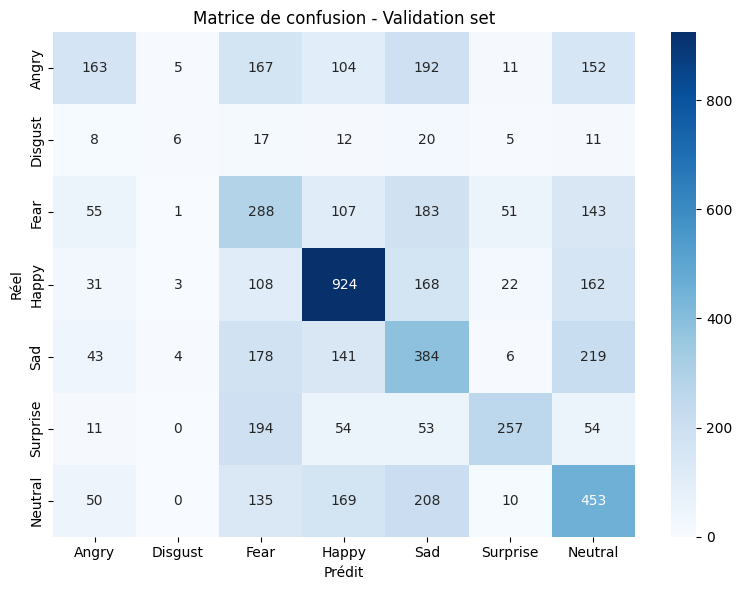

In [15]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Recharger le modèle entraîné
best_model = EmotionCNN().to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
best_model.eval()

# 2. Fonction pour évaluer et récupérer prédictions
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

# 3. Exécution
true_labels, predicted_labels = evaluate_model(best_model, val_loader)

# 4. Classification report
emotionLabels = {
    0: 'Angry', 1: 'Disgust', 2: 'Fear',
    3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
}

print(classification_report(true_labels, predicted_labels, target_names=emotionLabels.values()))

# 5. Matrice de confusion
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotionLabels.values(),
            yticklabels=emotionLabels.values())
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Validation set")
plt.tight_layout()
plt.show()


## 📊 Étape 5 — Évaluation finale du modèle

### 🔍 Résumé des métriques (validation set) :

- **Accuracy globale** : `43%` → le modèle est bien meilleur que le hasard (≈14% pour 7 classes), mais encore largement perfectible.
- **F1-score macro** : `0.37` → reflète le faible équilibre entre les classes (certaines sont bien reconnues, d'autres mal).
- **Support** : 5742 images en validation.

---

### 🧠 Analyse par classe :

| Émotion   | Précision | Recall | F1-score | Observations |
|-----------|-----------|--------|----------|--------------|
| Angry     | 0.45      | 0.21   | 0.28     | Beaucoup de confusion, surtout avec Sad et Fear. |
| Disgust   | 0.32      | 0.08   | 0.12     | Très faible support (≈79 images), classe minoritaire. |
| Fear      | 0.26      | 0.35   | 0.30     | Confondu avec Sad/Neutral. |
| Happy     | **0.61**  | **0.65** | **0.63** | Meilleure classe. Trait facial bien détecté (sourire). |
| Sad       | 0.32      | 0.39   | 0.35     | Correct mais confondu avec Neutral/Fear. |
| Surprise  | **0.71**  | 0.41   | 0.52     | Bonne précision mais rappel modéré. |
| Neutral   | 0.38      | 0.44   | 0.41     | Classe fréquente mais visuellement proche de Sad. |

---

### 📌 Matrice de confusion :

- **Happy** est bien prédit (924 bien classés sur 1418).
- **Fear, Sad et Neutral** sont très confondus entre eux.
- **Disgust** est très mal classé (seulement 6 vrais positifs sur 79 !).

---

### 💬 Interprétation :

- Le modèle a bien appris les classes **fréquentes et visuellement distinctes** (`Happy`, `Surprise`), mais peine sur :
  - Les **émotions subtiles ou proches** (`Fear`, `Sad`, `Neutral`)
  - Les classes **faiblement représentées** (`Disgust`)

Cela reflète **à la fois un déséquilibre de dataset et une limite de généralisation du modèle**.



# ETAPE 6 : Affichage des prédictions

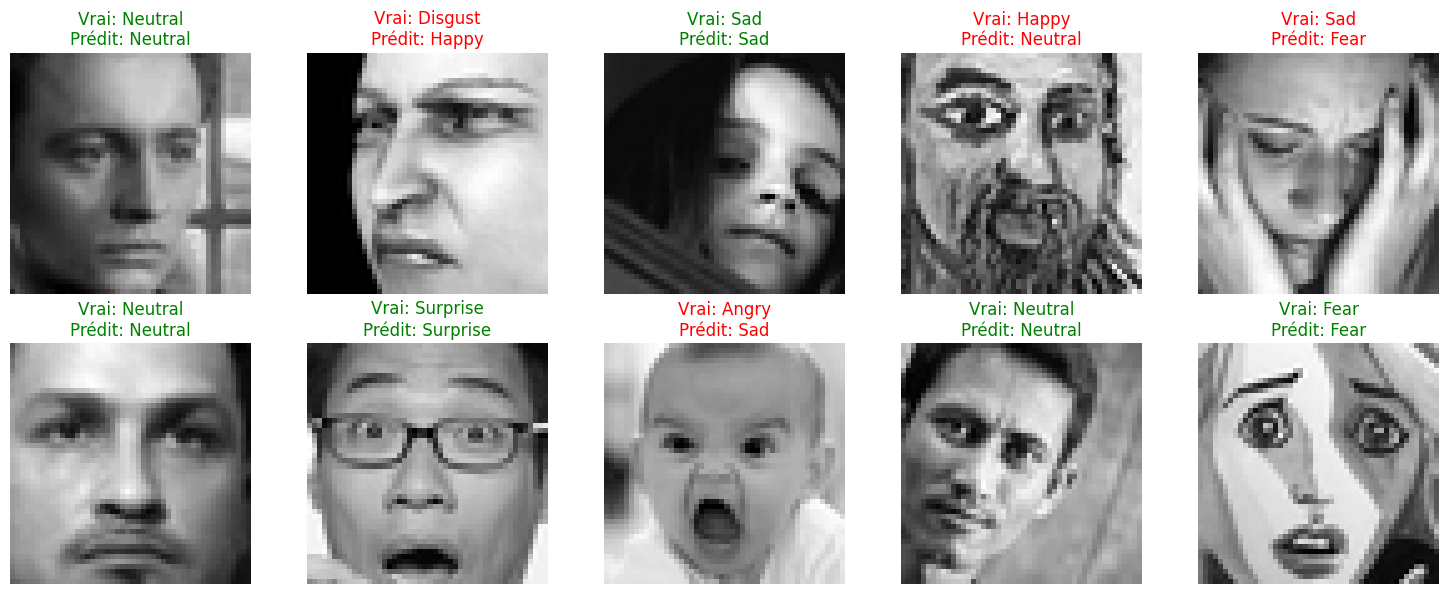

In [33]:
# Afficher des images avec leur vraie étiquette + prédiction
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

plt.figure(figsize=(15, 6))
for i in range(1, 11): 
    img = images[i][0].cpu().numpy()
    true_label = emotionLabels[labels[i].item()]
    pred_label = emotionLabels[preds[i].item()]
    color = "green" if true_label == pred_label else "red"

    plt.subplot(2, 5, i)  
    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(f"Vrai: {true_label}\nPrédit: {pred_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()


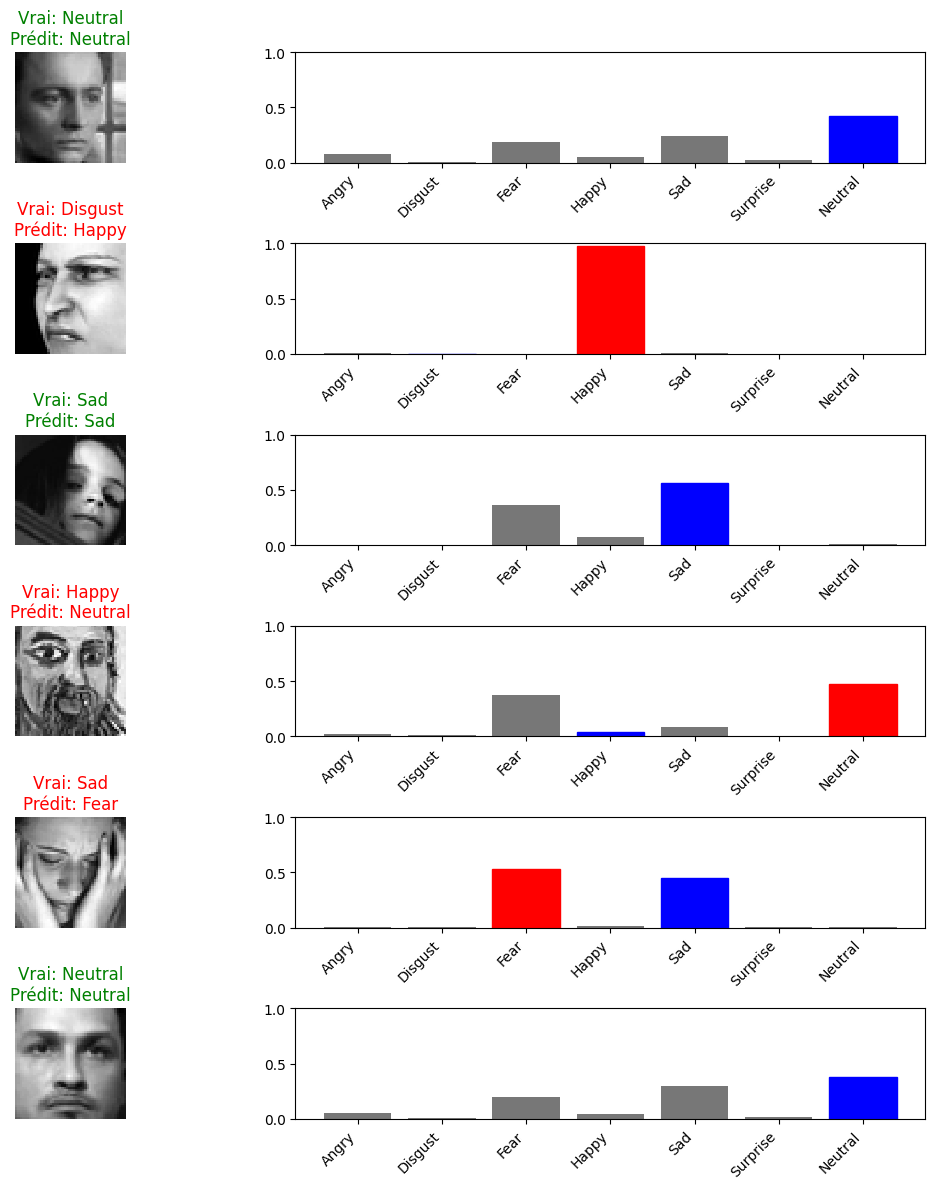

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Fonction pour afficher l'image + vraie/prédite + couleur verte/rouge
def plot_image_prediction(i, predictions_array, true_label, img):
    img = img[i][0].cpu().numpy()
    true = true_label[i].item()
    pred = int(np.argmax(predictions_array[i].cpu().numpy()))
    color = "green" if pred == true else "red"

    plt.imshow(img, cmap='gray', interpolation='nearest')
    plt.title(f"Vrai: {emotionLabels[true]}\nPrédit: {emotionLabels[pred]}", color=color)
    plt.axis('off')

# Fonction pour afficher la distribution des probabilités
def plot_value_prediction(i, predictions_array, true_label):
    true = true_label[i].item()
    pred = int(np.argmax(predictions_array[i].cpu().numpy()))
    thisplot = plt.bar(range(7), predictions_array[i].cpu().numpy(), color="#777777")
    plt.ylim([0, 1])
    thisplot[pred].set_color('red')
    thisplot[true].set_color('blue')
    plt.xticks(range(7), list(emotionLabels.values()), rotation=45, ha='right')

# Charger un batch
model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)

# Obtenir les prédictions (probabilités)
with torch.no_grad():
    outputs = model(images)
    probs = F.softmax(outputs, dim=1)

# Affichage combiné à partir de i=1
num_images = 6
plt.figure(figsize=(2 * 6, 2 * num_images))
for i in range(1, num_images + 1): 
    plt.subplot(num_images, 2, 2*(i-1)+1)
    plot_image_prediction(i, probs, labels, images)

    plt.subplot(num_images, 2, 2*(i-1)+2)
    plot_value_prediction(i, probs, labels)

plt.tight_layout()
plt.show()


Le graphe en barres montre :

en bleu : la vraie étiquette

en rouge : la prédiction du modèle

en gris : les autres classes